In [52]:
import pandas as pd

In [53]:
import numpy as np

In [54]:
data = pd.read_csv('train.csv')

In [55]:
data.head()

,target,f0,f1,f2,f3,f4,f5,f6,f7,f8,f9,f10,f11,f12,f13,f14,f15,f16,f17,f18,
0,1,10,2,6,23,3,28,0,0,1,0,0,3,0,2,1,4,2,23,2,...
1,1,4,0,1,10,1,13,0,0,2,1,0,4,1,0,4,3,0,11,15,...
2,1,0,0,2,0,0,1,0,0,0,1,0,1,0,0,6,14,1,4,3,...
3,1,7,0,1,16,5,12,1,0,1,0,0,1,0,0,0,2,0,5,2,...
4,0,1,2,4,5,1,4,1,3,0,0,0,1,0,2,2,1,1,1,1,...


In [56]:
X = data.as_matrix()[:,1:]
X = np.array(X, dtype=np.double)

In [62]:
Y = data.as_matrix()[:,0]
Y = np.array(Y, dtype=np.double)
Y[Y == 0.0] = -1.0

In [240]:
def smo_svm(X, Y, lambd = 1.0, kernl = lambda a, b : np.dot(a.T, b), max_passes = 100, tol = 1e-12):
    
    alpha = np.zeros(len(X))
    b = 0.0
    
    passes = 0
    iters = 0
    while passes < max_passes:
        
        if iters > 10000:
            print "10000 iters!!!"
            break
            
        num_changed_alphas = 0
        
        for i in xrange(len(X) - 1):

            Ei = svm_func(X[i,:], X, Y, alpha, b) - Y[i]
            
            if Y[i] * Ei < -tol and alpha[i] < lambd or Y[i] * Ei > tol and alpha[i] > 0.0:
                j = np.random.randint(i + 1, len(X))
                
                #print "optimizing %d %d" % (i, j)
                
                Ej = svm_func(X[j,:], X, Y, alpha, b) - Y[j]
                alpha_i_old = alpha[i]
                alpha_j_old = alpha[j]
                if (Y[i] != Y[j]):
                    L = max(0,alpha[j] - alpha[i])
                    H = min(lambd, lambd + alpha[j] - alpha[i])
                else:
                    L = max(0,alpha[i] + alpha[j] - lambd)
                    H = min(lambd,alpha[i] + alpha[j])
                    
                if (L == H):
                    continue
                    
                nu = 2 * kernl(X[i,:], X[j,:]) - kernl(X[i,:], X[i,:]) - kernl(X[j,:], X[j,:])
                
                if nu >= 0.0:
                    continue
                
                alpha[j] = alpha[j] - (Y[j] * (Ei - Ej)) / (nu)
                
                if alpha[j] > H:
                    alpha[j] = H
                
                if alpha[j] < L:
                    alpha[j] = L
                    
                if abs(alpha[j] - alpha_j_old) < 1e-7:
                    continue
                    
                alpha[i] = alpha[i] + Y[i] * Y[j] * (alpha_j_old - alpha[j])
                
                b1 = b - Ei - Y[i] * (alpha[i] - alpha_i_old) * kernl(X[i,:], X[i,:])\
                    - Y[j] * (alpha[j] - alpha_j_old) * kernl(X[i,:], X[j,:])

                b2 = b - Ej - Y[i] * (alpha[i] - alpha_i_old) * kernl(X[i,:], X[i,:])\
                    - Y[j] * (alpha[j] - alpha_j_old) * kernl(X[j,:], X[j,:])
                    
                if 0.0 < alpha[i] and alpha[i] < lambd:
                    b = b1
                elif 0.0 < alpha[j] and alpha[j] < lambd:
                    b = b2
                else:
                    b = (b1 + b2) / 2
                    
                num_changed_alphas = num_changed_alphas + 1
            
            iters += 1
            if iters % 10 == 0:
                print "%d iters done" % iters
            if num_changed_alphas == 0:
                passes += 1
            else:
                passes = 0
            

    return alpha, b

In [224]:
def svm_func(x, X, Y, alpha, b, ind = None, kernl = lambda a, b : np.dot(a.T, b)):
    if ind is None:
        ind = range(len(X));
    res = 0.0
    for i in xrange(len(alpha)):
        res += alpha[i] * Y[ind[i]] * kernl(X[ind[i],:], x)
    return res + b

In [207]:
def the_svm(X, Y, lambd = 1.0, kernl = lambda a, b : np.dot(a.T, b)):

    n_samples, n_features = X.shape

    M = np.zeros((n_samples, n_samples))

    for i in xrange(len(X)):
        for j in xrange(len(X)):
            M[i, j] = kernl(X[i,:], X[j,:]) * Y[i] * Y[j]
    
    P = cvxopt.matrix(M)
    q = cvxopt.matrix(np.ones(n_samples) * -1)
    A = cvxopt.matrix(Y, (1,n_samples))
    b = cvxopt.matrix(0.0)

    tmp1 = np.diag(np.ones(n_samples) * -1)
    tmp2 = np.identity(n_samples)
    G = cvxopt.matrix(np.vstack((tmp1, tmp2)))
    tmp1 = np.zeros(n_samples)
    tmp2 = np.ones(n_samples) * lambd
    h = cvxopt.matrix(np.hstack((tmp1, tmp2)))

    solution = cvxopt.solvers.qp(P, q, G, h, A, b)
    alpha = np.ravel(solution['x'])

    sv = alpha > 1e-5
    ind = np.arange(len(alpha))[sv]
    alpha = alpha[sv]
    svec = X[sv]
    svec_y = Y[sv]

    b = 0.0
    for n in range(len(alpha)):
        b += sv_y[n]
        b -= np.sum(alpha * sv_y * K[ind[n],sv])
    b /= len(alpha)
    
    return alpha, b, sv, sv_y, ind

In [259]:
x = np.array([[0.0, 0.0], [1.0, 0.0], [0.0, 1.0], [1.0, 1.4]])
y = np.array([1.0, -1.0, 1.0, -1.0])

In [261]:
alpha, b = smo_svm(x, y, lambd=100.0)
alpha, b

10 iters done
20 iters done
30 iters done
40 iters done
50 iters done
60 iters done
70 iters done
80 iters done
90 iters done
100 iters done


(array([ 2.,  2.,  0.,  0.]), 1.0)

[ 0.  0.] 1.0
[ 1.  0.] -1.0
[ 0.  1.] 1.0
[ 1.   1.4] -1.0


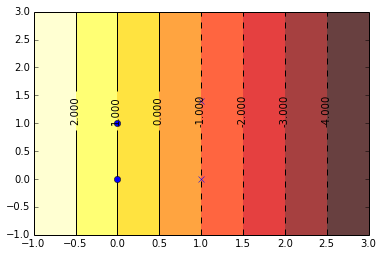

In [263]:
n = 10
xx = np.linspace(-1, 3, n)
yy = np.linspace(-1, 3, n)
XX, YY = np.meshgrid(xx, yy)

F = np.zeros_like(XX)
for i in xrange(len(xx)):
    for j in xrange(len(xx)):
        F[j, i] = svm_func(np.array([xx[i], yy[j]]), x, y, alpha, b)

contourf(xx, yy, F, 8, alpha=.75, cmap=cm.hot)
clabel(contour(xx, yy, F, 8, colors='black', linewidth=.5), inline=1, fontsize=10)
for i in xrange(len(x)):
    if y[i] == 1.0:
        plot(x[i,0], x[i,1], 'bo')
        print x[i,:], y[i]
    else:
        plot(x[i, 0], x[i,1], 'bx')
        print x[i,:], y[i]

In [264]:
x = np.random.randn(20,2)
x[10:,0] += 3
y = np.hstack((np.ones(10), np.ones(10) * -1))

In [265]:
alpha, b = smo_svm(x, y, lambd=10.0)
alpha, b

10 iters done
20 iters done
30 iters done
40 iters done
50 iters done
60 iters done
70 iters done
80 iters done
90 iters done
100 iters done
110 iters done
120 iters done
130 iters done
140 iters done
150 iters done
160 iters done
170 iters done
180 iters done
190 iters done
200 iters done
210 iters done
220 iters done
230 iters done
240 iters done
250 iters done
260 iters done
270 iters done
280 iters done
290 iters done
300 iters done
310 iters done
320 iters done
330 iters done
340 iters done
350 iters done
360 iters done
370 iters done
380 iters done
390 iters done
400 iters done
410 iters done
420 iters done
430 iters done
440 iters done
450 iters done
460 iters done
470 iters done
480 iters done
490 iters done
500 iters done
510 iters done
520 iters done
530 iters done
540 iters done
550 iters done
560 iters done


(array([ 1.14271944,  0.        ,  2.45594084,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  3.59866029,  0.        ,  0.        ,  0.        ]),
 3.5451602666968447)

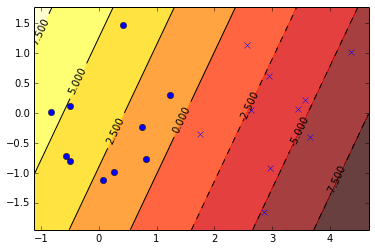

In [266]:
n = 10
xx = np.linspace(np.min(x[:,0])-0.3, np.max(x[:,0]) + 0.3, n)
yy = np.linspace(np.min(x[:,1])-0.3, np.max(x[:,1]) + 0.3, n)
XX, YY = np.meshgrid(xx, yy)

F = np.zeros_like(XX)
for i in xrange(len(xx)):
    for j in xrange(len(xx)):
        F[j,i] = svm_func(np.array([xx[i], yy[j]]), x, y, alpha, b)

contourf(xx, yy, F, 8, alpha=.75, cmap=cm.hot)
clabel(contour(xx, yy, F, 8, colors='black', linewidth=.5), inline=1, fontsize=10)
for i in xrange(len(x)):
    if y[i] == 1.0:
        plot(x[i,0], x[i,1], 'bo')
        #print x[i,:], y[i]
    else:
        plot(x[i, 0], x[i,1], 'bx')
        #print x[i,:], y[i]

In [286]:
def polynomial_kernel(x, y, p=2):
    return (1 + np.dot(x, y)) ** p

In [292]:
x = np.random.randn(20,2)
x[10:,0] += 2
x[10:,:] *= 1
y = np.hstack((np.ones(10), np.ones(10) * -1))

In [293]:
alpha, b = smo_svm(x, y, lambd=10.0, kernl=polynomial_kernel)
alpha, b

10 iters done
20 iters done
30 iters done
40 iters done
50 iters done
60 iters done
70 iters done
80 iters done
90 iters done
100 iters done
110 iters done
120 iters done
130 iters done
140 iters done
150 iters done
160 iters done
170 iters done
180 iters done
190 iters done
200 iters done
210 iters done
220 iters done
230 iters done
240 iters done
250 iters done
260 iters done
270 iters done
280 iters done
290 iters done
300 iters done
310 iters done
320 iters done
330 iters done
340 iters done
350 iters done
360 iters done
370 iters done
380 iters done
390 iters done
400 iters done
410 iters done
420 iters done
430 iters done
440 iters done
450 iters done
460 iters done
470 iters done
480 iters done
490 iters done
500 iters done
510 iters done
520 iters done
530 iters done
540 iters done
550 iters done
560 iters done
570 iters done
580 iters done
590 iters done
600 iters done
610 iters done
620 iters done
630 iters done
640 iters done
650 iters done
660 iters done
670 iters done
680 

(array([  1.86835761e-02,   1.00000000e+01,   0.00000000e+00,
         0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         1.00000000e+01,   0.00000000e+00,   9.94064926e+00,
         9.76388134e-03,   0.00000000e+00,   1.00000000e+01,
         5.71685546e+00,   0.00000000e+00,   0.00000000e+00,
         0.00000000e+00,   1.00000000e+01,   0.00000000e+00,
         4.25224126e+00,   0.00000000e+00]),
 1.4772561019286059)

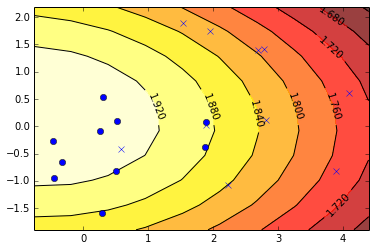

In [294]:
n = 10
xx = np.linspace(np.min(x[:,0])-0.3, np.max(x[:,0]) + 0.3, n)
yy = np.linspace(np.min(x[:,1])-0.3, np.max(x[:,1]) + 0.3, n)
XX, YY = np.meshgrid(xx, yy)

F = np.zeros_like(XX)
for i in xrange(len(xx)):
    for j in xrange(len(xx)):
        F[j,i] = svm_func(np.array([xx[i], yy[j]]), x, y, alpha, b, kernl=gaussian_kernel)

contourf(xx, yy, F, 8, alpha=.75, cmap=cm.hot)
clabel(contour(xx, yy, F, 8, colors='black', linewidth=.5), inline=1, fontsize=10)
for i in xrange(len(x)):
    if y[i] == 1.0:
        plot(x[i,0], x[i,1], 'bo')
        #print x[i,:], y[i]
    else:
        plot(x[i, 0], x[i,1], 'bx')
        #print x[i,:], y[i]

In [1]:
x = np.random.uniform?

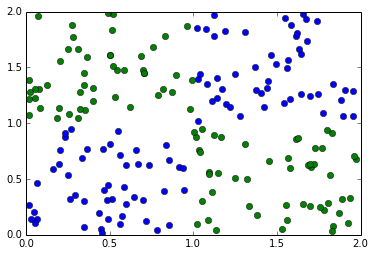

In [20]:
x = np.vstack((np.random.uniform(size=100).reshape((50,2)), np.random.uniform(size=100).reshape((50,2)) + 1)) 
plot(x[:,0], x[:,1], 'bo')
y1 = np.random.uniform(size=100).reshape((50,2))
y2 = np.random.uniform(size=100).reshape((50,2))
y1[:,0] += 1
y2[:,1] += 1
plot(y2[:,0], y2[:,1], 'go')
plot(y1[:,0], y1[:,1], 'go')

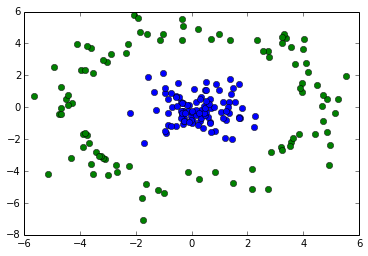

In [24]:
x = np.random.randn(100, 2)
r = np.abs(np.random.randn(100)) + 4
fi = np.random.uniform(0.0, 2 * np.pi, size = 100)
y = np.vstack((r * np.cos(fi), r * np.sin(fi))).T
plot(x[:,0], x[:,1], 'bo')
plot(y[:,0], y[:,1], 'go')

In [35]:
x.shape

(100, 2)

In [33]:
x.shape

(100, 2)

In [36]:
y.shape

(100, 2)

In [39]:
z = np.vstack((x,y))

In [40]:
zz = np.ones((200,3))

In [41]:
zz = np.ones((200,3))
zz[:,:2] = z


In [42]:
zz = np.ones((200,3))
zz[:,:2] = z
zz[:,2] = z[:,0] * z[:,0] + z[:,1] * z[:,1]

In [43]:
zz = np.ones((200,3))
zz[:,:2] = z
zz[:,2] = z[:,0] * z[:,0] + z[:,1] * z[:,1]
d = np.dot(zz - zz.mean(axis=0), np.linalg.eig(np.cov(zz.T))[1])[:,:2]

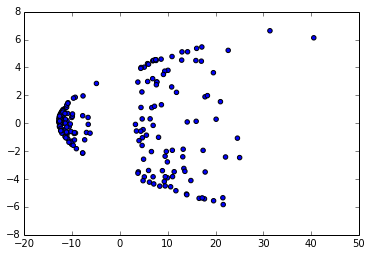

In [44]:
zz = np.ones((200,3))
zz[:,:2] = z
zz[:,2] = z[:,0] * z[:,0] + z[:,1] * z[:,1]
d = np.dot(zz - zz.mean(axis=0), np.linalg.eig(np.cov(zz.T))[1])[:,:2]
scatter(d[:,0], d[:,1], c=range(200))